# Computer Vision 
## Homework 2: Creating a 3D Stereo Image from Two Images Without Camera Intrinsic Parameters

Erin Akinjide

### Step 1: Detect and Match Feature Points 

- Use feature detectors such as SIFT, ORB, or Harris Corner Detector. 
- Find corresponding points between the two images using descriptor matching. 


Visualize the location and scale of the thirty strongest features in image1 and image 2.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import copy

Load images and convert to grayscale

In [2]:
img1_color = cv2.cvtColor(cv2.imread('000006-color.jpg'), cv2.COLOR_BGR2RGB)
img2_color = cv2.cvtColor(cv2.imread('000007-color.jpg'), cv2.COLOR_BGR2RGB)

# Load grayscale images
img1 = cv2.imread('000006-color.jpg', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('000007-color.jpg', cv2.IMREAD_GRAYSCALE)




Specify bounding box coordinates for finding the relevant keypoints

In [ ]:
# --- Manually define bounding box (xmin, ymin, xmax, ymax) in pixels ---
bbox_img1 = (200, 50, 400, 400)  
bbox_img2 = (200, 0, 420, 400)  

def filter_keypoints_in_bbox(keypoints, bbox):
    """Filter keypoints to only those within the specified bounding box.
    Args:
        keypoints: List of keypoints to filter.
        bbox: Bounding box defined as (x_min, y_min, x_max, y_max).
    Returns:
        List of keypoints that fall within the bounding box.
    """
    x_min, y_min, x_max, y_max = bbox
    filtered = []
    for kp in keypoints:
        x, y = kp.pt
        if x_min <= x <= x_max and y_min <= y <= y_max:
            filtered.append(kp)
    return filtered

In [ ]:
# SIFT 
sift = cv2.SIFT_create(nfeatures=500)

# Detect keypoints and compute descriptors
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# Apply bounding box filtering to extract keypoints on Cheez-it boxes
kp1_filtered = filter_keypoints_in_bbox(kp1, bbox_img1)
kp2_filtered = filter_keypoints_in_bbox(kp2, bbox_img2)

def extract_descriptors_for_keypoints(selected_kps, all_kps, all_desc):
    """Extract descriptors for the selected keypoints from the full set of keypoints and descriptors.
    Args:
        selected_kps: List of keypoints that are within the bounding box.
        all_kps: List of all keypoints detected in the image.
        all_desc: Corresponding descriptors for all keypoints.
    Returns:
        A numpy array of descriptors for the selected keypoints."""
    selected_desc = []
    for kp in selected_kps:
        idx = all_kps.index(kp)
        selected_desc.append(all_desc[idx])
    return np.array(selected_desc)

des1_filtered = extract_descriptors_for_keypoints(kp1_filtered, kp1, des1)
des2_filtered = extract_descriptors_for_keypoints(kp2_filtered, kp2, des2)

Algorithm for FLANN based matcher is from OpenCV's FLANN (Fast Library for Approximate Nearest Neighbors) module.

In [ ]:
#-- Step 2: Matching descriptor vectors with a FLANN based matcher
# Since SIFT is a floating-point descriptor NORM_L2 is used
matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)
knn_matches = matcher.knnMatch(des1_filtered, des2_filtered, 2)

In [6]:
#-- Filter matches using the Lowe's ratio test
ratio_thresh = 0.7
good_matches = []
for m,n in knn_matches:
    if m.distance < ratio_thresh * n.distance:
        good_matches.append(m)

In [14]:
#-- Draw matches
img_matches = np.empty((max(img1.shape[0], img2.shape[0]), img1.shape[1]+img2.shape[1], 3), dtype=np.uint8)
matched_img = matched_img = cv2.drawMatches(img1_color, kp1_filtered, img2_color, kp2_filtered, good_matches, None, flags=2)

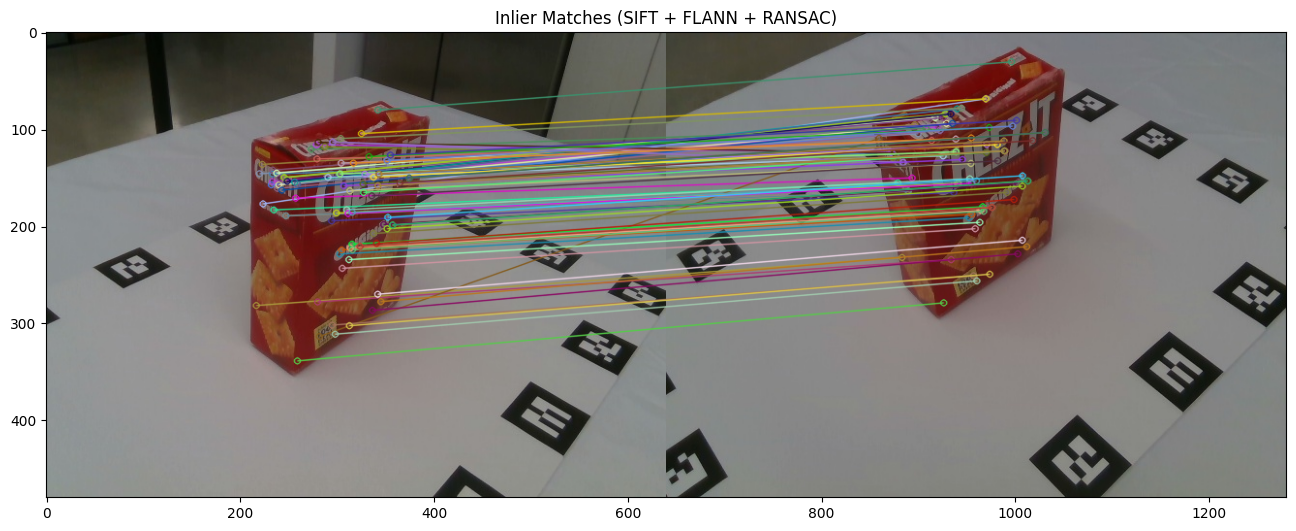

In [ ]:
# Visualize the matches within the bounding boxes

plt.figure(figsize=(16, 8))
plt.imshow(matched_img)
plt.title('Inlier Matches (SIFT + FLANN + RANSAC)')
plt.axis('on')
plt.show()


Now Visualize the location and scale of the thirty strongest features in image1 and image 2.

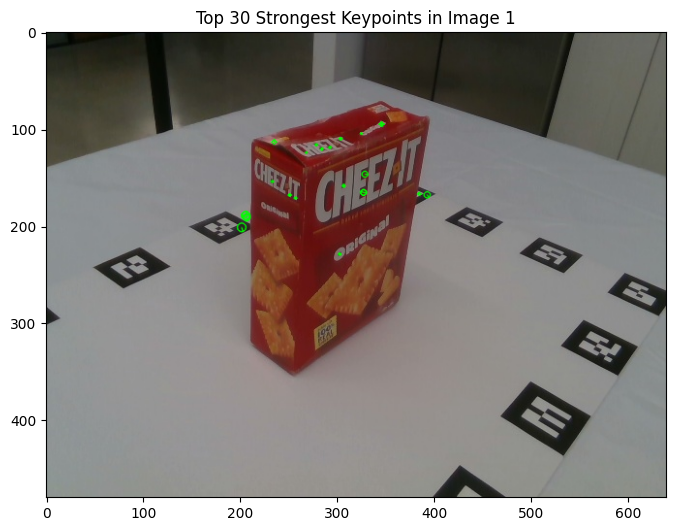

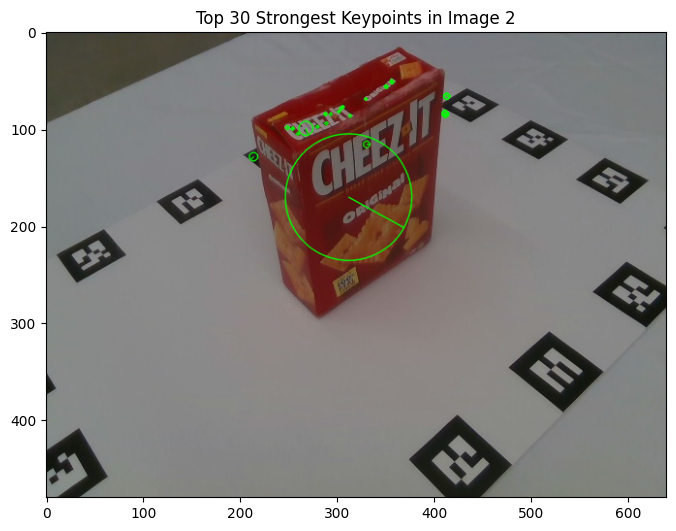

In [17]:
def draw_strongest_keypoints(image, keypoints, top_k=30, title=''):
    """    Draw the strongest keypoints on the image.
    Args:
        image: The input image.
        keypoints: The keypoints to draw.
        top_k: The number of strongest keypoints to draw.
        title: The title for the plot.
    """
    # Sort keypoints by response (strength)
    strongest_kps = sorted(keypoints, key=lambda x: -x.response)[:top_k]

    # Draw the strongest keypoints with scale
    image_with_kps = cv2.drawKeypoints(
        image,
        strongest_kps,
        outImage=None,
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS,
        color=(0, 255, 0)
    )

    # Display
    plt.figure(figsize=(8, 8))
    plt.imshow(image_with_kps)
    plt.title(title)
    plt.axis('on')
    plt.show()

# Visualize strongest features in both filtered images
draw_strongest_keypoints(img1_color, kp1_filtered, top_k=30, title='Top 30 Strongest Keypoints in Image 1')
draw_strongest_keypoints(img2_color, kp2_filtered, top_k=30, title='Top 30 Strongest Keypoints in Image 2')


### Step 2: Compute the Fundamental Matrix FF

- Estimate the Fundamental Matrix FF using RANSAC to remove outliers.

In [ ]:
""" #-- Step 2: Matching descriptor vectors with a FLANN based matcher
# Since SIFT is a floating-point descriptor NORM_L2 is used
matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)
knn_matches = matcher.knnMatch(des1_top, des2_top, 2) """